# 目的
LightGBMによる2ndStage

In [1]:
EXP_NAME = "e111-add-llm-embedding-300"
COMPETITION_NAME = "atmacup17"

DATA_PATH = "data"
ENV_PATH = "env_file"
MODEL_OUTPUT_PATH = f"trained_models/{EXP_NAME}"
TARGET_COL = "Recommended IND"

# experiment parameter
DEBUG = False
TRAINING = True
UPLOAD_DATA_TO_S3 = True
# UPLOAD_DATA_TO_KAGGLE = True
WANDB = True

In [2]:
import polars as pl
import numpy as np

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score

import lightgbm as lgb

import seaborn as sns

In [3]:
pl.__version__

'1.0.0'

In [4]:
lgb.__version__

'4.5.0'

In [5]:
def resolve_path(base_path: str) -> str:
    import os

    cwd = os.getcwd()
    print(cwd)
    if cwd == f"/notebooks":
        print("Jupyter Kernel By VSCode!")
        return "kernel", f"/notebooks/{COMPETITION_NAME}/{base_path}"
    elif cwd == f"/notebooks/{COMPETITION_NAME}":
        print("nohup!")
        return base_path
    elif cwd == f"/notebooks/{COMPETITION_NAME}/{COMPETITION_NAME}/exp":
        print("Jupyter Lab!")
        return "nohup", f"../../{base_path}"
    elif cwd == f"/content":
        print("Google Colab!")
        return "colab", f"/content/drive/MyDrive/Kaggle/{COMPETITION_NAME}/{base_path}"
    elif cwd.startswith("/home/shinichiro.saito"):
        print("GCP!")
        return "GCP", f"/home/shinichiro.saito/{COMPETITION_NAME}/{base_path}"
    else:
        raise Exception("Unknown environment")


ENV_NAME, DATA_PATH = resolve_path(DATA_PATH)
print(DATA_PATH)
_, MODEL_OUTPUT_PATH = resolve_path(MODEL_OUTPUT_PATH)
print(MODEL_OUTPUT_PATH)
_, ENV_PATH = resolve_path(ENV_PATH)

/home/shinichiro.saito/atmacup17/exp
GCP!
/home/shinichiro.saito/atmacup17/data
/home/shinichiro.saito/atmacup17/exp
GCP!
/home/shinichiro.saito/atmacup17/trained_models/e109-add-llm-embedding-300
/home/shinichiro.saito/atmacup17/exp
GCP!


In [6]:
import json

with open(f"{DATA_PATH}/rec_stratified_fold.json") as f:
    label_stratified_fold = json.load(f)

In [7]:
train = pl.read_csv(f"{DATA_PATH}/train_with_index.csv")
test = pl.read_csv(f"{DATA_PATH}/test.csv")
clothing_master = pl.read_csv(f"{DATA_PATH}/clothing_master.csv")

train = train.join(clothing_master, on="Clothing ID", how="left").with_columns(
    pl.col("index").replace(label_stratified_fold).alias("fold"),  # foldを追加する
    pl.col("Clothing ID").cast(pl.String),
)
test = test.join(clothing_master, on="Clothing ID", how="left").with_columns(
    pl.col("Clothing ID").cast(pl.String),
)

In [8]:
train

index,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,fold
i64,str,i64,str,str,i64,i64,i64,str,str,str,i64
0,"""0""",25,"""3-season skirt!""","""Adorable, well-made skirt! lin…",5,1,4,"""General""","""Bottoms""","""Skirts""",2
1,"""0""",39,"""Very cute""","""Love the asymmetrical hem. wai…",5,1,0,"""General""","""Bottoms""","""Skirts""",2
2,"""0""",42,"""Beautiful! fruns small for typ…","""I love this skirt! i wasn't su…",5,1,5,"""General""","""Bottoms""","""Skirts""",1
3,"""0""",45,null,"""I was really pleased with this…",5,1,9,"""General""","""Bottoms""","""Skirts""",0
4,"""0""",57,"""Unique, pretty asymmetric skir…","""I saw this skirt in retailer s…",5,1,1,"""General""","""Bottoms""","""Skirts""",1
…,…,…,…,…,…,…,…,…,…,…,…
9995,"""232""",57,"""Runs big on top""",null,3,1,5,"""General""","""Dresses""","""Dresses""",1
9996,"""232""",58,null,"""I loved the dress, but just no…",1,1,5,"""General""","""Dresses""","""Dresses""",0
9997,"""232""",60,"""I was really disappointed""","""I was really hoping this dress…",2,0,7,"""General""","""Dresses""","""Dresses""",1


# feature engineering

## DeBERTa xsmall oof pred

In [9]:
xsmall_oof = pl.read_csv(
    f"../trained_models/e004-0-1-2-ens/xsmall-fold-fix-oof.csv"
).rename({"valid_pred": "xsmall_pred"})

xsmall_pred = pl.read_csv(
    f"../trained_models/e004-0-1-2-ens/e004-0-1-2-ens-cv0.9590.csv"
)

In [10]:
train = train.join(
    xsmall_oof.select(pl.col(["index", "xsmall_pred"])), on="index", how="left"
)
test = test.with_columns(pl.Series(xsmall_pred).alias("xsmall_pred"))

# DeBERTa(all_info auxiliary loss) large oof pred

In [11]:
large_aux_oof_fold0 = pl.read_csv(
    "../trained_models/e032-lrg-fold0/valid_dataset_e032-lrg-fold0.csv"
)
large_aux_oof_fold1 = pl.read_csv(
    "../trained_models/e033-lrg-fold1/valid_dataset_e033-lrg-fold1.csv"
)
large_aux_oof_fold2 = pl.read_csv(
    "../trained_models/e034-lrg-fold2/valid_dataset_e034-lrg-fold2.csv"
)

large_aux_pred_fold0 = pl.read_csv(
    "../trained_models/e032-lrg-fold0/submission_e032-lrg-fold0_cv0.9720.csv"
)
large_aux_pred_fold1 = pl.read_csv(
    "../trained_models/e033-lrg-fold1/submission_e033-lrg-fold1_cv0.9715.csv"
)
large_aux_pred_fold2 = pl.read_csv(
    "../trained_models/e034-lrg-fold2/submission_e034-lrg-fold2_cv0.9669.csv"
)

large_aux_oof = pl.concat(
    [large_aux_oof_fold0, large_aux_oof_fold1, large_aux_oof_fold2], how="vertical"
)
large_aux_pred = (
    large_aux_pred_fold0 + large_aux_pred_fold1 + large_aux_pred_fold2
) / 3

In [12]:
train = train.join(
    large_aux_oof.select(pl.col(["index", "valid_pred"])), on="index", how="left"
).rename({"valid_pred": "large_aux_pred"})
test = test.with_columns(pl.Series(large_aux_pred).alias("large_aux_pred"))

# LLM Embedding

In [13]:
train_emb = np.load(f"{DATA_PATH}/train_embeddings_reduced.npy")
test_emb = np.load(f"{DATA_PATH}/test_embeddings_reduced.npy")

In [14]:
print(train_emb.shape)
print(test_emb.shape)

(10000, 300)
(11155, 300)


In [15]:
train_emb = pl.DataFrame(train_emb, schema=[f"llm_{i}" for i in range(300)])
test_emb = pl.DataFrame(test_emb, schema=[f"llm_{i}" for i in range(300)])

In [16]:
train = pl.concat([train, train_emb], how="horizontal")
test = pl.concat([test, test_emb], how="horizontal")

In [17]:
USE_COL = [
    "Clothing ID",
    "Age",
    "Positive Feedback Count",
    "Division Name",
    "Department Name",
    "Class Name",
    "xsmall_pred",
    "large_aux_pred",
]
USE_COL += [f"llm_{i}" for i in range(300)]
CATEGORICAL_FEATURE = ["Clothing ID", "Division Name", "Department Name", "Class Name"]
TARGET_COL = "Recommended IND"
FOLD_NUM = 3
SEED = 42

In [18]:
# Categorical型への変換
train = train.with_columns(pl.col(CATEGORICAL_FEATURE).cast(pl.Categorical))
test = test.with_columns(pl.col(CATEGORICAL_FEATURE).cast(pl.Categorical))

In [31]:
# LightGBMで用いるパラメータを指定
params = {
    "objective": "binary",
    "metric": "auc",
    "max_depth": 3,
    "min_data_in_leaf": 10,  # 1つの葉に入る最小のデータ数
    "num_leaves": 24,  # 2**max_depthより少し小さめにすると過学習を防げる
    "learning_rate": 0.001,  # 1回のiterationで学習を進める割合、大きいと学習が早く終わる。小さいと学習は長いが高精度になりやすい。
    "bagging_freq": 5,  # 指定した回数ごとにbaggingを行う
    "feature_fraction": 0.9,  # 1回のiterationで利用する特徴量(列方向)の割合
    "bagging_fraction": 0.8,  # 1回のiterationで利用するデータ(行方向)の割合
    "verbose": -1,  # 出力するログレベルの変更、-1はFatalなログのみを出力
    "seed": SEED,  # ランダムシードの固定
    "lambda_l1": 0.4,  # 正則化のためのパラメータ
    "lambda_l2": 0.4,  # 正則化のためのパラメータ
}

In [32]:
# テストデータに対する推論、特徴量重要度(後述)を計算するために、モデルを保存するobjectを作成
models = []

# Cross Validationによる学習の実施
for fold in range(FOLD_NUM):
    print(f"Start fold {fold}")

    # foldごとにtrainとvalidに分ける
    train_fold = train.filter(pl.col("fold") != fold)
    valid_fold = train.filter(pl.col("fold") == fold)

    # X(説明変数)とy(目的変数)に分ける
    X_train = train_fold.select(USE_COL)
    X_valid = valid_fold.select(USE_COL)
    y_train = train_fold.select(TARGET_COL)
    y_valid = valid_fold.select(TARGET_COL)

    # LightGBMが認識可能な形にデータセットを変換
    lgb_train = lgb.Dataset(X_train.to_pandas(), y_train.to_pandas())
    lgb_eval = lgb.Dataset(
        X_valid.to_pandas(), y_valid.to_pandas(), reference=lgb_train
    )

    # モデルの学習
    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=10000,  # 学習のiteration回数
        valid_sets=[lgb_train, lgb_eval],
        callbacks=[
            lgb.early_stopping(
                stopping_rounds=100
            ),  # Early stopingの回数、binary_loglossが改善しないiterationが100回続いたら学習を止める
            lgb.log_evaluation(100),  # 指定したiteration回数ごとにlogを出力する
        ],
    )

    # モデルを保存
    models.append([fold, model])

Start fold 0
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.97415	valid_1's auc: 0.972544
[200]	training's auc: 0.974479	valid_1's auc: 0.972474
Early stopping, best iteration is:
[127]	training's auc: 0.974228	valid_1's auc: 0.972728
Start fold 1
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.97396	valid_1's auc: 0.967442
[200]	training's auc: 0.974952	valid_1's auc: 0.970844
Early stopping, best iteration is:
[199]	training's auc: 0.974971	valid_1's auc: 0.970849
Start fold 2
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.975288	valid_1's auc: 0.965145
[200]	training's auc: 0.976267	valid_1's auc: 0.966675
Early stopping, best iteration is:
[160]	training's auc: 0.975982	valid_1's auc: 0.966793


In [33]:
# 学習データ全体に対する推論結果を保存するobjectを作成
oof = np.zeros((len(train)))

scores = []
# foldの値と学習済みモデルを利用し、モデルの評価を行う
for fold, model in models:
    valid_fold = train.filter(pl.col("fold") == fold)

    X_valid = valid_fold.select(USE_COL)
    y_valid = valid_fold.select(TARGET_COL)

    # validデータに対する推論
    y_valid_pred = model.predict(
        X_valid.to_pandas(), num_iteration=model.best_iteration
    )

    score = roc_auc_score(y_valid, y_valid_pred)
    scores.append(score)
    print(f"fold {fold} Score: {score}")

    is_valid = train.get_column("fold") == fold
    oof[is_valid] = y_valid_pred

fold 0 Score: 0.9727282979761034
fold 1 Score: 0.9708493673313117
fold 2 Score: 0.9667932899626666


In [34]:
# cv_score = roc_auc_score(train.get_column(TARGET_COL), oof)
# cv_score
# foldごとの平均をとる
cv_score = np.mean(scores)
cv_score

0.9701236517566939

<Axes: >

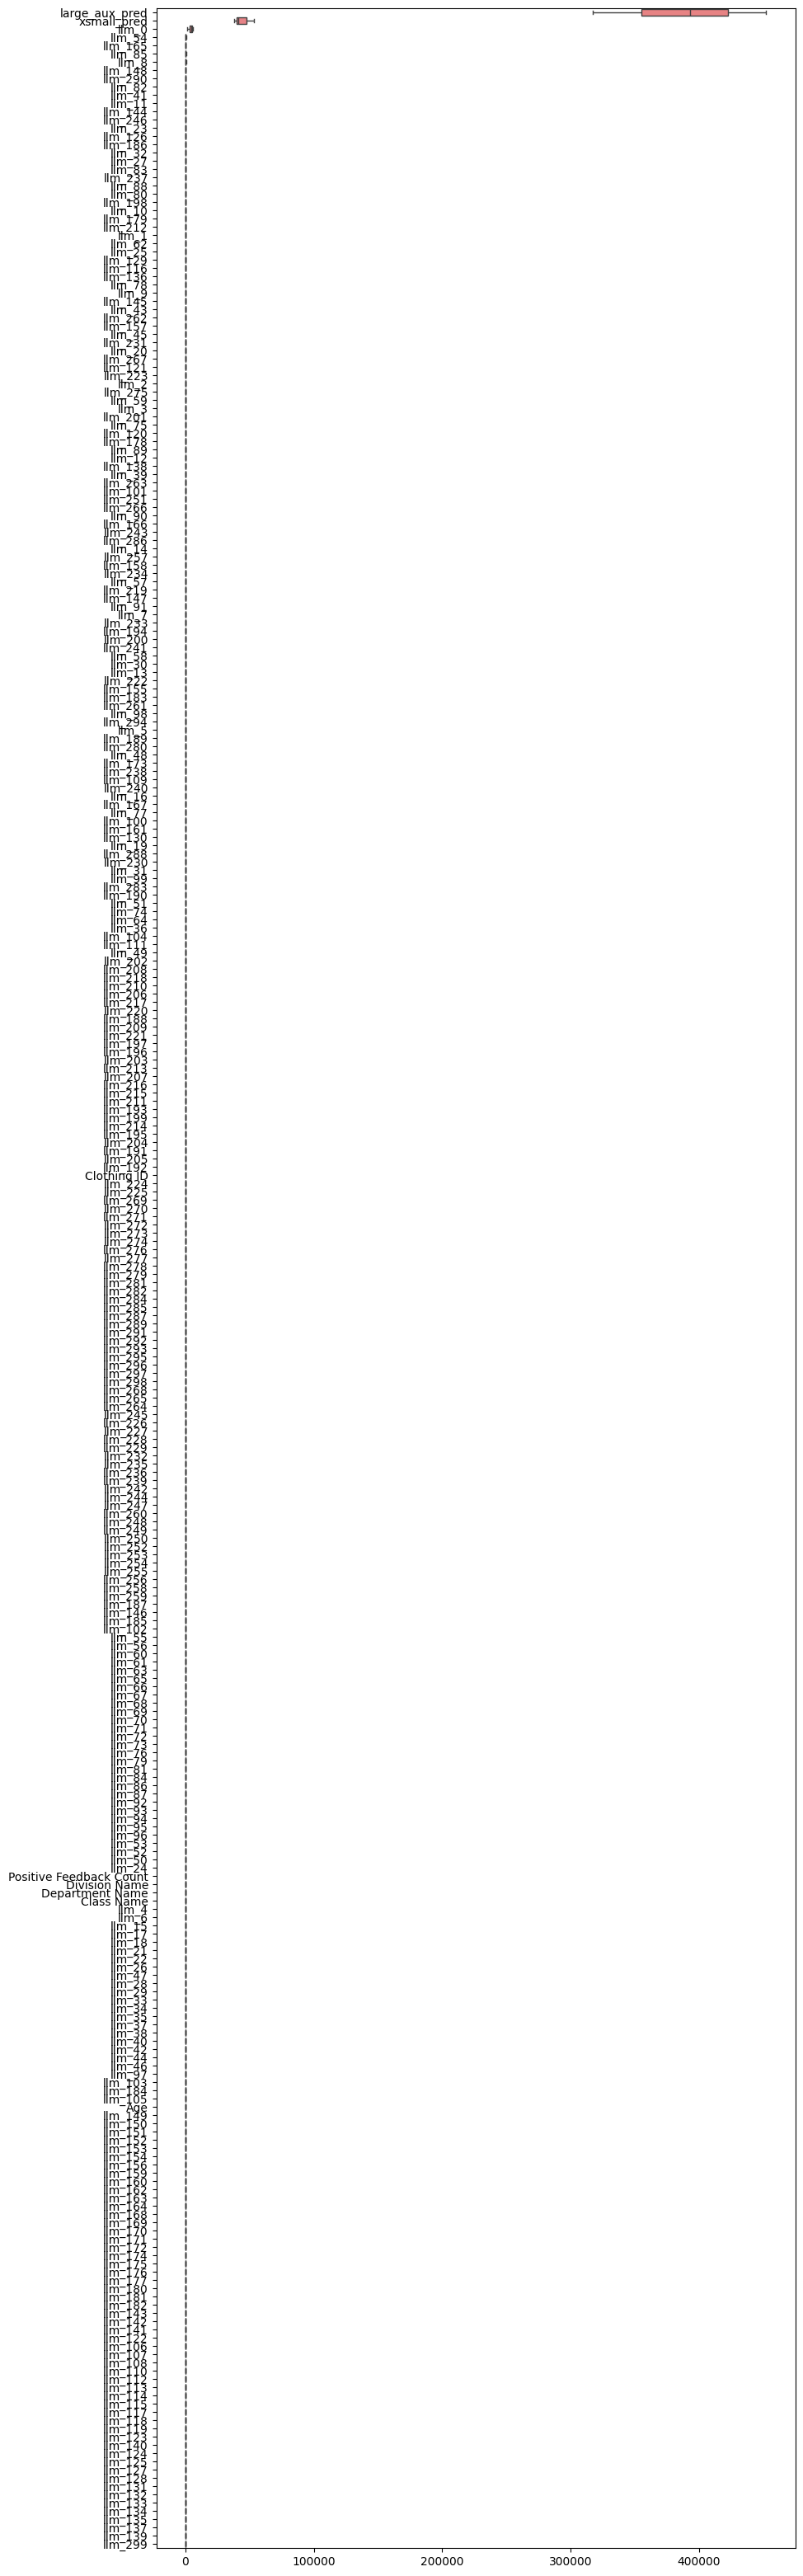

In [38]:
import pandas as pd

feature_importances = [
    model.feature_importance(importance_type="gain") for _, model in models
]
feature_importances_df = pd.DataFrame(feature_importances, columns=USE_COL)

order = feature_importances_df.mean().sort_values(ascending=False).index.tolist()

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 40))
sns.boxplot(data=feature_importances_df, orient="h", order=order)

In [24]:
pred = np.array([model.predict(test[USE_COL].to_pandas()) for _, model in models])
pred = np.mean(pred, axis=0)
pred

array([0.89171961, 0.66463539, 0.89171961, ..., 0.89171961, 0.89171961,
       0.89171961])

In [25]:
import os

os.makedirs(MODEL_OUTPUT_PATH, exist_ok=True)

sample_submission = pl.read_csv(f"{DATA_PATH}/sample_submission.csv")

if DEBUG:
    sample_submission = sample_submission.head(100)

(
    sample_submission.with_columns(pl.Series(pred).alias("target")).write_csv(
        f"{MODEL_OUTPUT_PATH}/submission_{EXP_NAME}_cv{cv_score:.4f}.csv"
    )
)